In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(4)
client

<Client: scheduler='tcp://146.118.38.54:38559' processes=0 cores=0>

In [12]:
#from soda.dataio.suntans.sunpy import Spatial
import xarray as xr
import dask
import glob
from netCDF4 import Dataset
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb

from soda.dataio.suntans.sunxray import Sundask
from soda.utils.myproj import MyProj
from soda.utils.otherplot import axcolorbar

import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

#plt.rcParams['animation.ffmpeg_path'] = '/pawsey/sles12sp3/tools/broadwell/gcc/4.8.5/ffmpeg/3.4/bin/ffmpeg'
#plt.rcParams['axes.labelsize'] = 'large'
#plt.rcParams["font.size"] = "14"
#mpl.verbose.set_level("helpful")

#%matplotlib inline

In [4]:
#ncfiles = '../SCENARIOS/NWS_2km_hex_2013_2014_data6/NWS_2km_hex_20131201.*'
#ncfiles = '../SCENARIOS/NWS_2km_hex_2013_2014_data3/NWS_2km_hex_*.nc.*'
ncfiles = '../SCENARIOS/NWS_2km_hex_2019_data3/NWS_2km_hex_*.nc.*'


In [5]:
sun = Sundask(ncfiles)
sun._ds

Time dimension time
converting variable: xp
converting variable: yp


<xarray.Dataset>
Dimensions:       (Nc: 976, Ne: 3116, Nk: 100, Nkw: 101, Np: 454016, Two: 2, numsides: 8, time: 721)
Coordinates:
    xv            (Nc) float64 dask.array<chunksize=(976,), meta=np.ndarray>
    yv            (Nc) float64 dask.array<chunksize=(976,), meta=np.ndarray>
    xe            (Ne) float64 dask.array<chunksize=(3116,), meta=np.ndarray>
    ye            (Ne) float64 dask.array<chunksize=(3116,), meta=np.ndarray>
    z_r           (Nk) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    z_w           (Nkw) float64 dask.array<chunksize=(101,), meta=np.ndarray>
    Nk            (Nc) int32 dask.array<chunksize=(976,), meta=np.ndarray>
  * time          (time) datetime64[ns] 2019-04-01T00:00:30 ... 2019-05-01
Dimensions without coordinates: Nc, Ne, Nkw, Np, Two, numsides
Data variables:
    suntans_mesh  int32 ...
    cells         (Nc, numsides) int32 dask.array<chunksize=(976, 8), meta=np.ndarray>
    face          (Nc, numsides) int32 dask.array<chunksize=

In [6]:
# Compute the grid properties before gradient calculation
sun.calc_all_properties()


In [7]:
P = MyProj('merc')


In [8]:
# Convert the suntans coordinates to lat/lon
sun.xp, sun.yp = P.to_ll(sun.xp, sun.yp)
sun.xv, sun.yv = P.to_ll(sun.xv, sun.yv)
P._xy = None # reset this
## Convert latlon to map coordinate
#sun.xp, sun.yp = ax(sun.xp, sun.yp)
#sun.xv, sun.yv = ax(sun.xv, sun.yv)
#sun.xy = sun.cellxy(sun.xp, sun.yp)


In [19]:
# Plot one time step
t=620
klayer = 0
temp_now = sun.load_data('temp',tstep=t, klayer=klayer)
clim = [26,32]

In [20]:
%%time
# Compute the gradient
dTdx, dTdy = sun.calc_grad(temp_now)
dT = np.abs(dTdx + 1j*dTdy)

CPU times: user 153 ms, sys: 40.2 ms, total: 193 ms
Wall time: 438 ms


In [21]:
titlestr = 'Time: %s\nDepth: %3.0f m'%(str(sun._ds.time.values[t])[0:19].replace('T',' '),sun._ds.z_r[klayer])
titlestr

'Time: 2019-04-26 20:00:00\nDepth:   4 m'

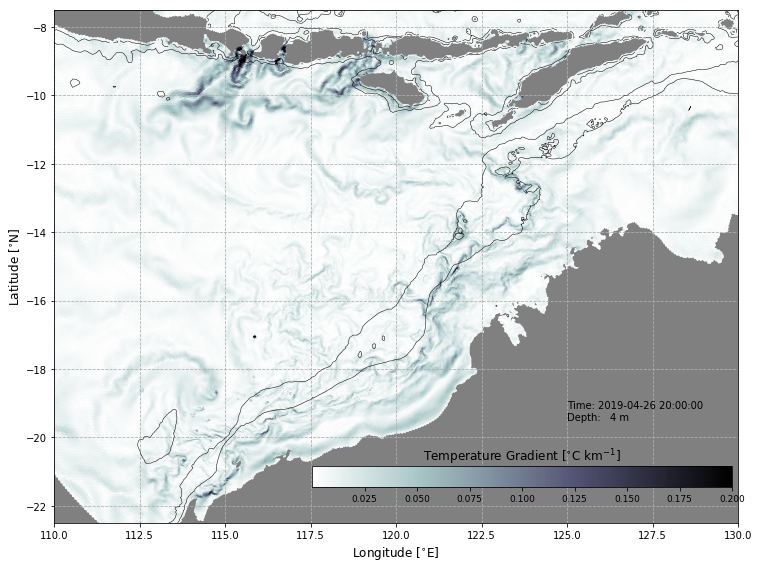

In [22]:
plt.figure(figsize=(12,8))
ax=plt.subplot(111, facecolor='0.5')
fig,ax,cf,cb = sun.plotcelldata(dT*1e3, cmap='bone_r', vmax=0.2, colorbar=False)

sun.contourf(sun.dv, clevs = [200.,1000.], filled=False, colors='k', linewidths=0.5)

plt.grid(ls='--',b=True)
title = ax.text(125,-19.5,titlestr)

plt.ylabel('Latitude [$^{\circ}$N]')
plt.xlabel('Longitude [$^{\circ}$E]')

plt.xlim(110,130)
plt.ylim(-22.5,-7.5)

cb=axcolorbar(cf, pos=[0.4,0.07,0.5,0.04])
cb.ax.set_title('Temperature Gradient [$^{\circ}$C km$^{-1}$]')

plt.show()

In [23]:
timesteps = slice(0,720)
klayer = 0
outpath = '../FIGURES/suntans_April2019_surface_gradT'
#####

# Load the data before
timedays = range(timesteps.start,timesteps.stop,1)
new_value = sun.load_data('temp',tstep=timesteps, klayer=klayer)

# Make the animation
def init():
    return cf, title

def update_time(t):
    if t%24==0:
        print(t)
    
    # Calculate the gradient 
    dTdx, dTdy = sun.calc_grad(new_value[t,:])
    dT = np.abs(dTdx + 1j*dTdy)
    
    cf.set_array(dT*1e3)
    #cf.set_edgecolors(None)
    cf.set_edgecolors(cf.to_rgba(np.array((dT*1e3))))
    #cf.set_zorder(-1e6)
    fig.canvas.draw()

    #title.set_text('Year Day: %3.2f'%(t) )
    titlestr = 'Time: %s\nDepth: %3.0f m'%(str(sun._ds.time.values[t])[0:19].replace('T',' '),sun._ds.z_r[klayer])
    title.set_text(titlestr)


    return cf, title


#timedays =  [0,0.1,0.2]
#timedays = np.arange(0,2,1/48.)
#timedays = np.arange(0,28,1/48.)
anim = animation.FuncAnimation(fig, update_time,\
    init_func=init, frames=timedays,  blit=True)
    #init_func=init, frames=[1,2], interval=50, blit=True)


#anim.save("%s.gif"%outpath,writer='imagemagick',fps=12, dpi=90)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg_file']
writer = Writer(fps=24, metadata=dict(artist='Matt Rayson'), bitrate=3600, codec='mpeg4')

anim.save("%s.avi"%outpath, writer=writer)
print('Saved to %s.avi'%outpath)


0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
Saved to ../FIGURES/suntans_April2019_surface_gradT.avi


# Compute the free-surface gradient

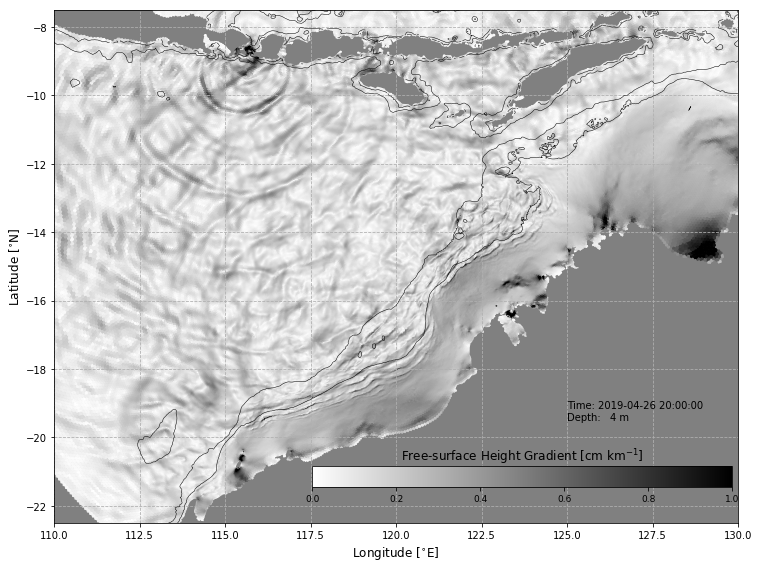

In [24]:
# Plot one time step
t=620
temp_now = sun.load_data('eta',tstep=t)
clim = [26,32]
dTdx, dTdy = sun.calc_grad(temp_now)
dT = np.abs(dTdx + 1j*dTdy)

titlestr = 'Time: %s\nDepth: %3.0f m'%(str(sun._ds.time.values[t])[0:19].replace('T',' '),sun._ds.z_r[klayer])

                         
plt.figure(figsize=(12,8))
ax=plt.subplot(111, facecolor='0.5')
fig,ax,cf,cb = sun.plotcelldata(dT*1e5, cmap='gray_r',vmin=0,vmax=1., colorbar=False)

sun.contourf(sun.dv, clevs = [200.,1000.], filled=False, colors='k', linewidths=0.5)

plt.grid(ls='--',b=True)
title = ax.text(125,-19.5,titlestr)

plt.ylabel('Latitude [$^{\circ}$N]')
plt.xlabel('Longitude [$^{\circ}$E]')

plt.xlim(110,130)
plt.ylim(-22.5,-7.5)

cb=axcolorbar(cf, pos=[0.4,0.07,0.5,0.04])
cb.ax.set_title('Free-surface Height Gradient [cm km$^{-1}$]')

plt.show()

In [25]:
timesteps = slice(0,720)
klayer = 0
outpath = '../FIGURES/suntans_April2019_surface_gradSSH'
#####

# Load the data before
timedays = range(timesteps.start,timesteps.stop,1)
new_value = sun.load_data('eta',tstep=timesteps)

# Make the animation
def init():
    return cf, title

def update_time(t):
    if t%24==0:
        print(t)
    
    # Calculate the gradient 
    dTdx, dTdy = sun.calc_grad(new_value[t,:])
    dT = np.abs(dTdx + 1j*dTdy)
    
    cf.set_array(dT*1e5)
    #cf.set_edgecolors(None)
    cf.set_edgecolors(cf.to_rgba(np.array((dT*1e5))))
    #cf.set_zorder(-1e6)
    fig.canvas.draw()

    #title.set_text('Year Day: %3.2f'%(t) )
    titlestr = 'Time: %s\nDepth: %3.0f m'%(str(sun._ds.time.values[t])[0:19].replace('T',' '),sun._ds.z_r[klayer])
    title.set_text(titlestr)


    return cf, title


#timedays =  [0,0.1,0.2]
#timedays = np.arange(0,2,1/48.)
#timedays = np.arange(0,28,1/48.)
anim = animation.FuncAnimation(fig, update_time,\
    init_func=init, frames=timedays,  blit=True)
    #init_func=init, frames=[1,2], interval=50, blit=True)


#anim.save("%s.gif"%outpath,writer='imagemagick',fps=12, dpi=90)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg_file']
writer = Writer(fps=24, metadata=dict(artist='Matt Rayson'), bitrate=3600, codec='mpeg4')

anim.save("%s.avi"%outpath, writer=writer)
print('Saved to %s.avi'%outpath)


0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
Saved to ../FIGURES/suntans_April2019_surface_gradSSH.avi


# Compute the low-frequency SSH gradient

In [9]:
timesteps = slice(0,720)
klayer = 0
outpath = '../FIGURES/suntans_April2019_surface_gradSSH'
#####

# Load the data before
timedays = range(timesteps.start,timesteps.stop,1)
new_value = sun.load_data('eta',tstep=timesteps)

In [14]:
%%time
btype = 'low'
cutoff_dt = 34*3600.
dt = 3600.
order = 3

Wn = dt/cutoff_dt
            
(b, a) = signal.butter(order, Wn, btype=btype, analog=0, output='ba')

filt_value = signal.filtfilt(b, a, new_value, axis=0)

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


CPU times: user 4.4 s, sys: 16.2 s, total: 20.6 s
Wall time: 36.9 s


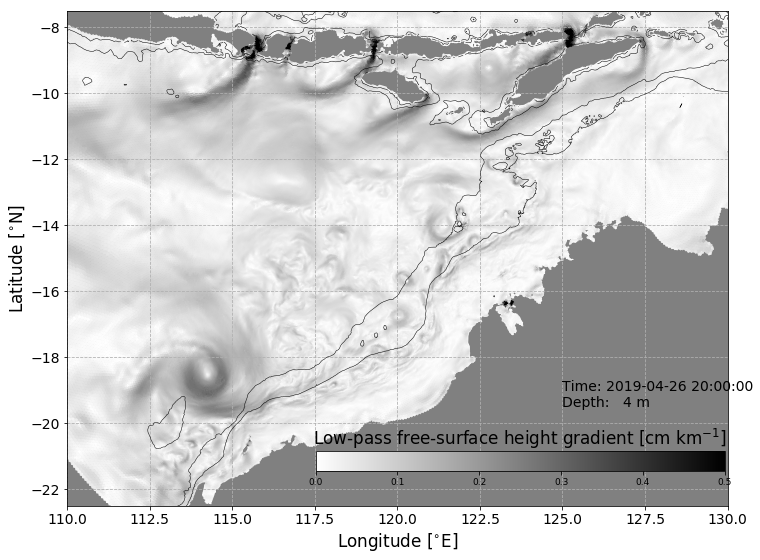

In [19]:
# Plot one time step
t=620
temp_now = filt_value[t,:]
clim = [26,32]
dTdx, dTdy = sun.calc_grad(temp_now)
dT = np.abs(dTdx + 1j*dTdy)

titlestr = 'Time: %s\nDepth: %3.0f m'%(str(sun._ds.time.values[t])[0:19].replace('T',' '),sun._ds.z_r[klayer])

                         
plt.figure(figsize=(12,8))
ax=plt.subplot(111, facecolor='0.5')
fig,ax,cf,cb = sun.plotcelldata(dT*1e5, cmap='gray_r',vmin=0,vmax=0.5, colorbar=False)

sun.contourf(sun.dv, clevs = [200.,1000.], filled=False, colors='k', linewidths=0.5)

plt.grid(ls='--',b=True)
title = ax.text(125,-19.5,titlestr)

plt.ylabel('Latitude [$^{\circ}$N]')
plt.xlabel('Longitude [$^{\circ}$E]')

plt.xlim(110,130)
plt.ylim(-22.5,-7.5)

cb=axcolorbar(cf, pos=[0.4,0.07,0.5,0.04])
cb.ax.set_title('Low-pass free-surface height gradient [cm km$^{-1}$]')

plt.show()

In [20]:
timesteps = slice(0,720)
klayer = 0
outpath = '../FIGURES/suntans_April2019_surface_lowfreq_gradSSH'
#####

# Load the data before
timedays = range(timesteps.start,timesteps.stop,1)

# Make the animation
def init():
    return cf, title

def update_time(t):
    if t%24==0:
        print(t)
    
    # Calculate the gradient 
    dTdx, dTdy = sun.calc_grad(filt_value[t,:])
    dT = np.abs(dTdx + 1j*dTdy)
    
    cf.set_array(dT*1e5)
    #cf.set_edgecolors(None)
    cf.set_edgecolors(cf.to_rgba(np.array((dT*1e5))))
    #cf.set_zorder(-1e6)
    fig.canvas.draw()

    #title.set_text('Year Day: %3.2f'%(t) )
    titlestr = 'Time: %s\nDepth: %3.0f m'%(str(sun._ds.time.values[t])[0:19].replace('T',' '),sun._ds.z_r[klayer])
    title.set_text(titlestr)


    return cf, title


#timedays =  [0,0.1,0.2]
#timedays = np.arange(0,2,1/48.)
#timedays = np.arange(0,28,1/48.)
anim = animation.FuncAnimation(fig, update_time,\
    init_func=init, frames=timedays,  blit=True)
    #init_func=init, frames=[1,2], interval=50, blit=True)


#anim.save("%s.gif"%outpath,writer='imagemagick',fps=12, dpi=90)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg_file']
writer = Writer(fps=24, metadata=dict(artist='Matt Rayson'), bitrate=3600, codec='mpeg4')

anim.save("%s.avi"%outpath, writer=writer)
print('Saved to %s.avi'%outpath)


0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
Saved to ../FIGURES/suntans_April2019_surface_lowfreq_gradSSH.avi


# Surface temperature plot

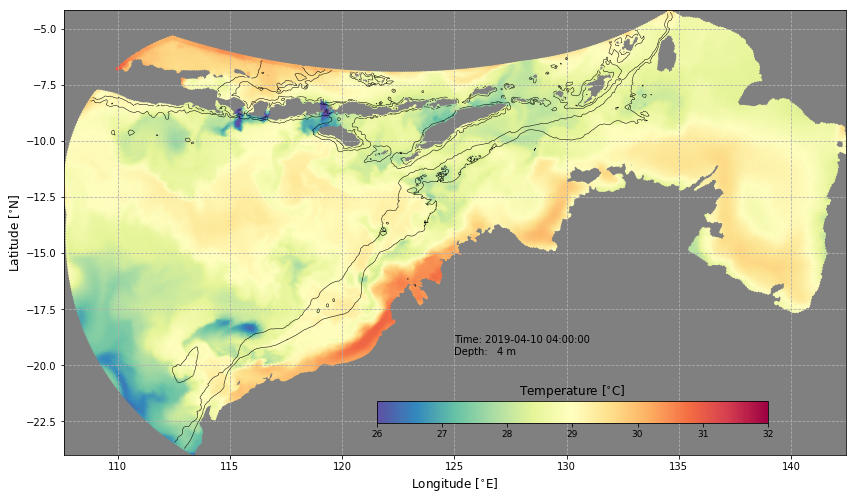

In [21]:
plt.figure(figsize=(12,8))
ax=plt.subplot(111, facecolor='0.5')
fig,ax,cf,cb = sun.plotcelldata(temp_now, cmap='Spectral_r',vmin=clim[0], vmax=clim[1], colorbar=False)

sun.contourf(sun.dv, clevs = [200.,1000.], filled=False, colors='k', linewidths=0.5)

plt.grid(ls='--',b=True)
title = ax.text(125,-19.5,titlestr)

plt.ylabel('Latitude [$^{\circ}$N]')
plt.xlabel('Longitude [$^{\circ}$E]')

cb=axcolorbar(cf, pos=[0.4,0.15,0.5,0.04])
cb.ax.set_title('Temperature [$^{\circ}$C]')

plt.show()

In [22]:
timesteps = slice(0,720)
klayer = 0
outpath = '../FIGURES/suntans_April2019_surface_T'
#####

# Load the data before
timedays = range(timesteps.start,timesteps.stop,1)
new_value = sun.load_data('temp',tstep=timesteps, klayer=klayer)

# Make the animation
def init():
    return cf, title

def update_time(t):
    if t%24==0:
        print(t)

    cf.set_array(new_value[t,:])
    #cf.set_edgecolors(None)
    cf.set_edgecolors(cf.to_rgba(np.array((new_value[t,:]))))
    #cf.set_zorder(-1e6)
    fig.canvas.draw()

    #title.set_text('Year Day: %3.2f'%(t) )
    titlestr = 'Time: %s\nDepth: %3.0f m'%(str(sun._ds.time.values[t])[0:19].replace('T',' '),sun._ds.z_r[klayer])
    title.set_text(titlestr)


    return cf, title


#timedays =  [0,0.1,0.2]
#timedays = np.arange(0,2,1/48.)
#timedays = np.arange(0,28,1/48.)
anim = animation.FuncAnimation(fig, update_time,\
    init_func=init, frames=timedays,  blit=True)
    #init_func=init, frames=[1,2], interval=50, blit=True)


#anim.save("%s.gif"%outpath,writer='imagemagick',fps=12, dpi=90)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg_file']
writer = Writer(fps=24, metadata=dict(artist='Matt Rayson'), bitrate=3600, codec='mpeg4')

anim.save("%s.avi"%outpath, writer=writer)
print('Saved to %s.avi'%outpath)


0
24
48
72
96
120
144
168
192
216
240
264
288
312
336
360
384
408
432
456
480
504
528
552
576
600
624
648
672
696
Saved to ../FIGURES/suntans_April2019_surface_T.avi


In [13]:
!which ffmpeg
!ffmpeg -codecs

/pawsey/sles12sp3/tools/broadwell/gcc/4.8.5/ffmpeg/3.4/bin/ffmpeg
ffmpeg version 3.4 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 4.8 (SUSE Linux)
  configuration: --prefix=/pawsey/sles12sp3/tools/broadwell/gcc/4.8.5/ffmpeg/3.4 --cc=gcc --cxx=g++ --enable-pic --enable-shared
  libavutil      55. 78.100 / 55. 78.100
  libavcodec     57.107.100 / 57.107.100
  libavformat    57. 83.100 / 57. 83.100
  libavdevice    57. 10.100 / 57. 10.100
  libavfilter     6.107.100 /  6.107.100
  libswscale      4.  8.100 /  4.  8.100
  libswresample   2.  9.100 /  2.  9.100
Codecs:
 D..... = Decoding supported
 .E.... = Encoding supported
 ..V... = Video codec
 ..A... = Audio codec
 ..S... = Subtitle codec
 ...I.. = Intra frame-only codec
 ....L. = Lossy compression
 .....S = Lossless compression
 -------
 D.VI.S 012v                 Uncompressed 4:2:2 10-bit
 D.V.L. 4xm                  4X Movie
 D.VI.S 8bps                 QuickTime 8BPS video
 .EVIL. a64_multi            Multicolor 

In [36]:
ncpu = 6
for rank in range(ncpu):
    print(np.arange(rank,144,ncpu))

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138]
[  1   7  13  19  25  31  37  43  49  55  61  67  73  79  85  91  97 103
 109 115 121 127 133 139]
[  2   8  14  20  26  32  38  44  50  56  62  68  74  80  86  92  98 104
 110 116 122 128 134 140]
[  3   9  15  21  27  33  39  45  51  57  63  69  75  81  87  93  99 105
 111 117 123 129 135 141]
[  4  10  16  22  28  34  40  46  52  58  64  70  76  82  88  94 100 106
 112 118 124 130 136 142]
[  5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 101 107
 113 119 125 131 137 143]


In [36]:
7%7

0